## 2nd Project

###  Instructions
- Follow a Python Project structure.
- Work with a training and validation dataset to optimize & test your trading strategies using the datasets provided in the introduction section.
- Select n technical indicators (one for each team member).
- For each timeframe train/test files (1d, 1h, 5m, 1m):
    - Define buy/sell signals for each indicator.
    - Create all possible combinations of all technical indicators (2^n - 1).
    - Backtest the strategies while keeping track of the operations and cash/portfolio value time series, remember that we'll be opening long & short positions.
    - Optimize all technical indicator's parameters (TPE, Grid Search, PSO, Genetic Algorithms, ...), stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!
    - Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).
    - Now, use the optimal strategy with the test dataset and compare it to a passive strategy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

data = pd.read_csv('data/aapl_5m_train.csv')

data = data.dropna()

rsi_data = ta.momentum.RSIIndicator(close = data.Close, window= 14)
data['RSI'] = rsi_data.rsi()

short_ma  = ta.trend.SMAIndicator(data.Close, window=5)
long_ma  = ta.trend.SMAIndicator(data.Close, window=21)
data["SHORT_SMA"] = short_ma.sma_indicator()
data["LONG_SMA"] = long_ma.sma_indicator()

macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()
data['Signal_Line'] = macd.macd_signal()

data['SAR'] = ta.trend.PSARIndicator(data['High'], data['Low'], data['Close'], step=0.02, max_step=0.2).psar()

adx_indicator = ta.trend.ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
data['ADX'] = adx_indicator.adx()
data['+DI'] = adx_indicator.adx_pos()
data['-DI'] = adx_indicator.adx_neg()
data['prev_DI+'] = data['+DI'].shift(1)
data['prev_DI-'] = data['-DI'].shift(1)

data = data.dropna()

In [2]:
data = pd.read_csv('data/aapl_5m_train.csv')
data.isna().sum()

Unnamed: 0      0
Timestamp       0
Gmtoffset       0
Datetime        0
Open            4
High            4
Low             4
Close           4
Volume        419
dtype: int64

In [3]:
data = pd.read_csv('data/aapl_5m_train.csv')


adx_indicator = ta.trend.ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
data['ADX'] = adx_indicator.adx()
data['+DI'] = adx_indicator.adx_pos()
data['-DI'] = adx_indicator.adx_neg()
data['prev_DI+'] = data['+DI'].shift(1)
data['prev_DI-'] = data['-DI'].shift(1)
data.isna().sum()

Unnamed: 0        0
Timestamp         0
Gmtoffset         0
Datetime          0
Open              4
High              4
Low               4
Close             4
Volume          419
ADX           27510
+DI           27510
-DI           27510
prev_DI+      27510
prev_DI-      27510
dtype: int64

In [4]:
data = pd.read_csv('data/aapl_5m_train.csv')
data = data.dropna()


adx_indicator = ta.trend.ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
data['ADX'] = adx_indicator.adx()
data['+DI'] = adx_indicator.adx_pos()
data['-DI'] = adx_indicator.adx_neg()
data['prev_DI+'] = data['+DI'].shift(1)
data['prev_DI-'] = data['-DI'].shift(1)
data.isna().sum()

Unnamed: 0    0
Timestamp     0
Gmtoffset     0
Datetime      0
Open          0
High          0
Low           0
Close         0
Volume        0
ADX           0
+DI           0
-DI           0
prev_DI+      1
prev_DI-      1
dtype: int64

In [5]:
len(data)  #only RSI

39160

In [6]:
len(data)  #only SMA

39160

In [29]:
len(data ) #only MACD

39127

In [31]:
len(data ) #only SAR

39160

In [19]:
len(data ) #only ADX

12001

In [31]:
len(data) #all

39127

In [10]:
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI
13,13,1609774500,0,2021-01-04 15:35:00,130.680694,131.139999,130.559997,131.115097,1150255.0,36.865564
14,14,1609774800,0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.884280
15,15,1609775100,0,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,32.020190
16,16,1609775400,0,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.523450
17,17,1609775700,0,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.909727


### RSI

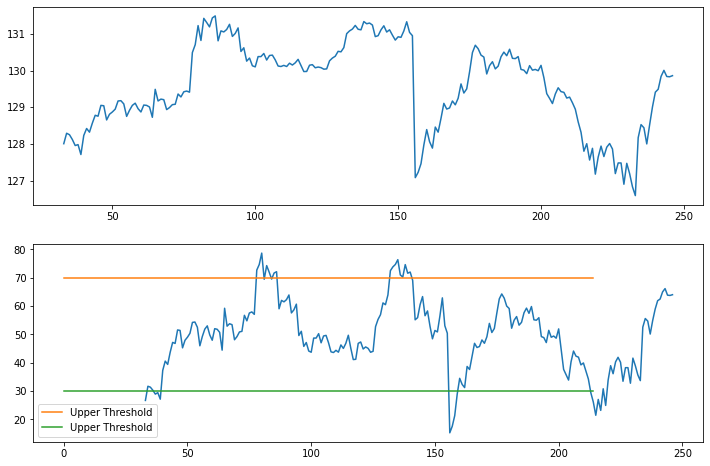

In [2]:
fig, axs = plt.subplots(2, 1, figsize = (12,8))


axs[0].plot(data.Close[:214])


axs[1].plot(data.RSI[:214])
axs[1].plot([0, 214], [70,70], label = "Upper Threshold")
axs[1].plot([0, 214], [30,30], label = "Upper Threshold")
plt.legend()

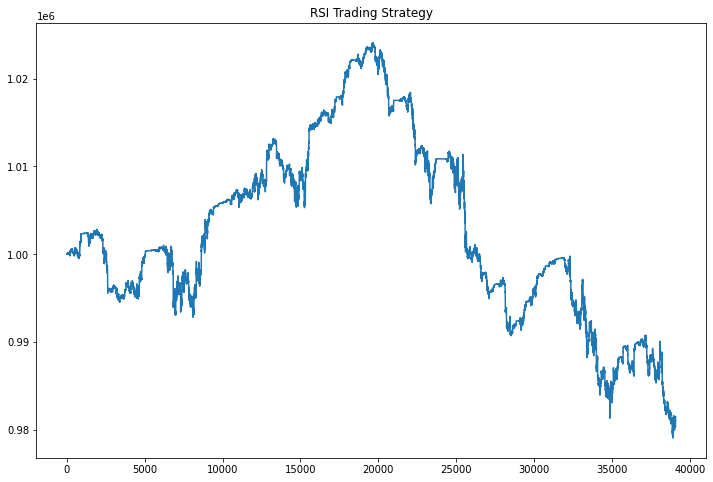

In [3]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for i, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)  
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares *  (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    if cash > row.Close * n_shares * (1 + com):   
        # Buy signal
        if row.RSI < 30:
            active_operations.append(Operation(operation_type = 'long', 
                                               bought_at = row.Close, 
                                               timestamp = row.Timestamp, 
                                               n_shares = n_shares,
                                               stop_loss = row.Close * 0.95,
                                               take_profit = row.Close * 1.05))
            cash -= row.Close * n_shares *  (1 + com)
            
    else:
        print('no money available..')
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
        
        
plt.figure(figsize = (12, 8))
plt.plot(strategy_value)
plt.title('RSI Trading Strategy')
plt.show()

### SMA

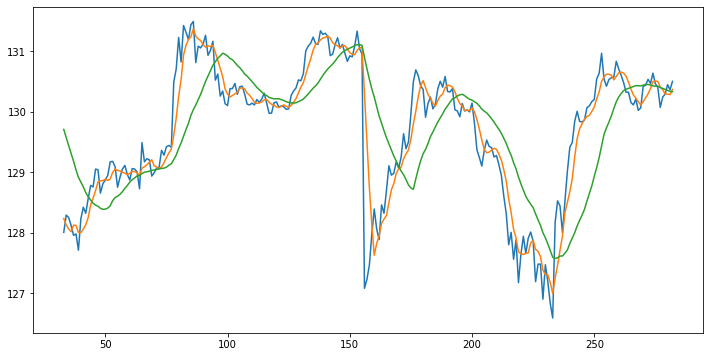

In [4]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close[:250], label = 'price')
plt.plot(data.SHORT_SMA[:250], label = 'SAM(5)')
plt.plot(data.LONG_SMA[:250], label = 'SMA(21)')

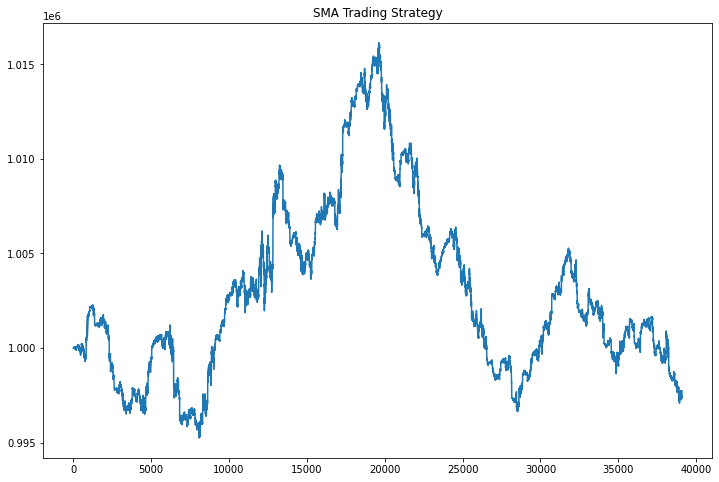

In [5]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

sma_sell_signal = data.iloc[0].LONG_SMA > data.iloc[0].SHORT_SMA 
sma_buy_signal = data.iloc[0].LONG_SMA < data.iloc[0].SHORT_SMA


for i, row in data.iterrows():
    # Close operations
    temp_operations = []
    for op in active_operations:
        # Close losing position
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)  
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares *  (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    if cash > row.Close * n_shares * (1 + com):   
        # Buy signal
        if (row.LONG_SMA < row.SHORT_SMA) and SMA_buy_signal == False:
            SMA_buy_signal =True
            #buy....
            active_operations.append(Operation(operation_type = 'long', 
                                               bought_at = row.Close, 
                                               timestamp = row.Timestamp, 
                                               n_shares = n_shares,
                                               stop_loss = row.Close * 0.95,
                                               take_profit = row.Close * 1.05))
            cash -= row.Close * n_shares *  (1 + com)
            
        elif row.LONG_SMA > row.SHORT_SMA:
            SMA_buy_signal =False
        
            
    else:
        print('no money available..')
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
    
    
plt.figure(figsize = (12, 8))
plt.plot(strategy_value)
plt.title('SMA Trading Strategy')
plt.show()

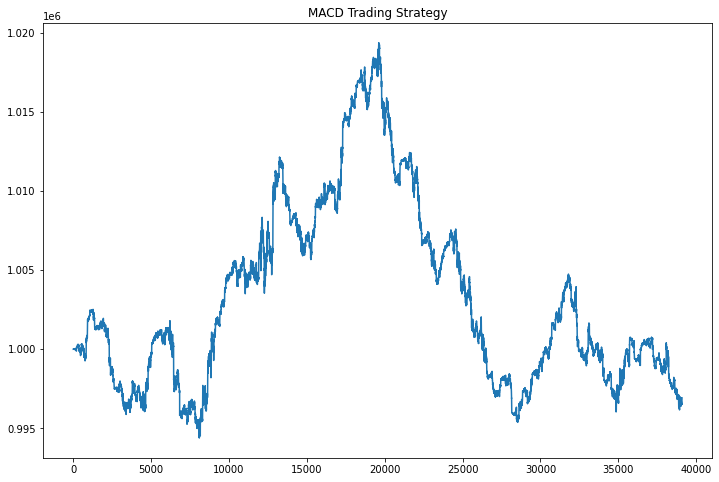

In [6]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for i, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close: 
            cash += row.Close * op.n_shares * (1 - com)
        elif op.take_profit < row.Close:  
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    # Verificamos si tenemos suficiente efectivo
    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra: la línea MACD cruza por encima de la línea de señal
        prev_macd = data['MACD'].shift(1)[i]  # Valor MACD de la fila anterior
        prev_signal = data['Signal_Line'].shift(1)[i]  # Valor de la línea de señal de la fila anterior
        if row['MACD'] > row['Signal_Line'] and prev_macd < prev_signal:
            active_operations.append(Operation(operation_type='long',
                                                bought_at=row.Close,
                                                timestamp=row.Timestamp,
                                                n_shares=n_shares,
                                                stop_loss=row.Close * 0.95,
                                                take_profit=row.Close * 1.05))
            cash -= row.Close * n_shares * (1 + com)
    else:
        print('no money available..')
    
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('MACD Trading Strategy')
plt.show()

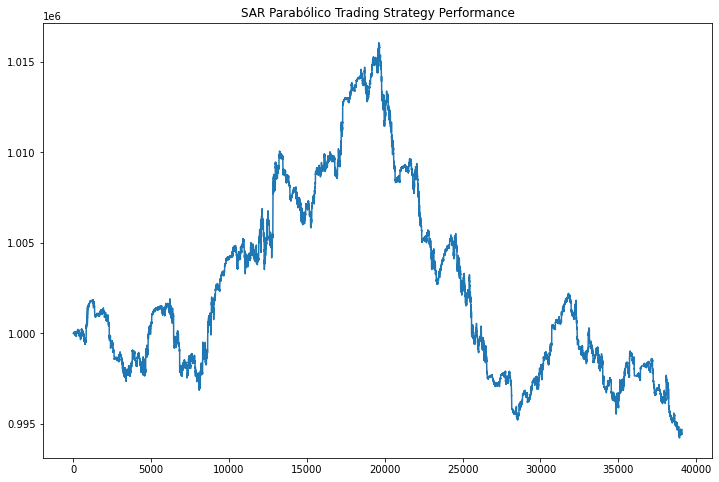

In [7]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10
data['prev_SAR'] = data['SAR'].shift(1)

for index, row in data.iterrows():

    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close or op.take_profit < row.Close:
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations

    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra: puntos del SAR pasan de estar arriba a debajo del precio
        if pd.notnull(row['prev_SAR']):  # Asegura que el valor previo de SAR no sea NaN
            if row['SAR'] < row['Close'] and row['prev_SAR'] > row['Close']:
                active_operations.append(Operation('long', row.Close, row.Timestamp, n_shares, row.Close * 0.95, row.Close * 1.05))
                cash -= row.Close * n_shares * (1 + com)

    
    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('SAR Parabólico Trading Strategy Performance')
plt.show()

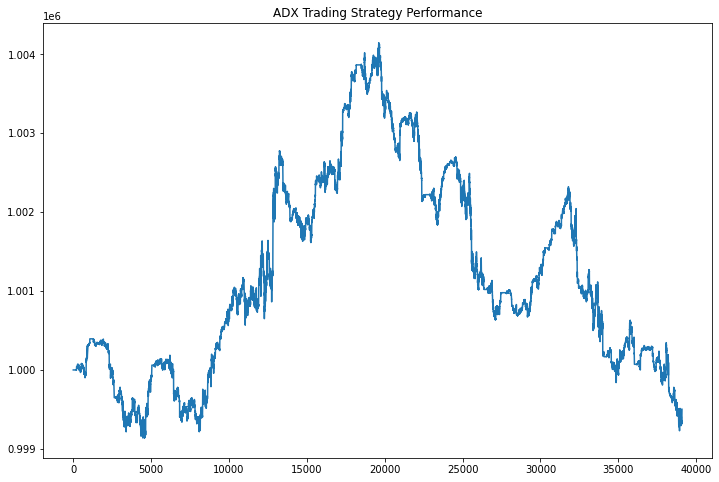

In [10]:

data = data.dropna()

cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for index, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close or op.take_profit < row.Close:
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations

    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra
        if pd.notnull(row['prev_DI+']) and pd.notnull(row['prev_DI-']):  # Verifica que los valores previos no sean NaN
            if row['+DI'] > row['-DI'] and row['ADX'] > 25 and row['prev_DI+'] < row['prev_DI-']:
                active_operations.append(Operation('long', row.Close, row.Timestamp, n_shares, row.Close * 0.95, row.Close * 1.05))
                cash -= row.Close * n_shares * (1 + com)


    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('ADX Trading Strategy Performance')
plt.show()